<a href="https://colab.research.google.com/github/malvibid/COMP3029-Computer-Vision/blob/main/COMP3029_Computer_Vision_Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COMP3029 COMPUTER VISION COURSEWORK** 

*Spring 2022/2023*, School of Computer Science, University of Nottingham Malaysia

```
GROUP 4: 
  20306551 - Mustafa Mehmood
  20311657 - Omar Ismail
  20311860 - Gabriel Hoh Chao Jei
  20187945 - Malvi Bid
```





# ⏳To-do

💎 Have set-up the whole infrastructure for running experiments ([utility functions](#scrollTo=COnU5pJu9lWI)). Now we have to actually use it to conduct experiments and test different hyper-parameters to find the best model. 

💎 Perform analysis of the experiments. Show how we selected the best model (selection criteria).

💎 Visualise models


# ⚡Challenges

```
Key: ✅ Challenge solved 🟥 Pending solution
```

*   ✅ 6 images in Batch-3 were not being segmented correctly. I double-checked the bounding box coordinates and drew them on the image, they were positioned correctly. After further inspection I realised the issue was with the PIL image library we were using. Therefore, I switched to using OpenCV, this resolved the issue. 

# Import Dependencies

In [1]:
# WandB for monitoring performance
!pip install wandb -q
!wandb login

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 25.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 10.2 MB/s eta 0:00:00


In [3]:
import wandb
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchmetrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import resnet18
from google.colab import drive
from google.colab.patches import cv2_imshow
from tqdm.auto import tqdm


# Mount google drive

In [4]:
# Mount drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


**Note:** Please see [Dataset folder structure](#scrollTo=09El4KoosQMe) section to understand how we have organised the directories.

Here is the link to the Google drive Datasets folder: [Datasets](https://drive.google.com/drive/folders/1VnbniSCDbDz16yzc5iVqjeMDGkbuJuwt?usp=sharing) (requires access).

You can add this folder to your own Google Drive by right-clicking on it and selecting "Add shortcut to Drive".


In [5]:
# Setting path to the datasets root folder
dataset_root_dir = '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/'

# Dataset folder structure

In [ ]:
!ls -F '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/'

Batch-1/  Batch-2/  Batch-3/


In [ ]:
print("Batch-1/ ")
!ls -F -X '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-1'
print("\nBatch-2/ ")
!ls -F -X '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-2'
print("\nBatch-3/ ")
!ls -F -X '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-3'

Batch-1/ 
seedsegment@  seedsplit@

Batch-2/ 
NormalRoomLighting@  seedcropped/  seedsegment/  NormalRoomLight_annotation.csv

Batch-3/ 
LightBox@  seedcropped/  seedsegment/  LightBox_annotation.csv


## Dataset structure tree

### Original folders tree


```
.
└── Datasets/
    ├── Batch-1/
    │   └── seedsegment/
    │       ├── test/
    │       │   ├── BadSeed/
    │       │   └── GoodSeed/
    │       │
    │       └── train/
    │           ├── BadSeed/
    │           └── GoodSeed/
    │
    ├── Batch-2/
    │   ├── NormalRoomLight_annotation.csv
    │   └── NormalRoomLighting/
    │       ├── Set1/
    │       ├── ...
    │       └── Set15/
    │
    └── Batch-3/
        ├── LightBox_annotation.csv
        └── LightBox/
            ├── Set1/
            ├── ...
            └── Set20/
```

### Folders tree after extracting Batch-2 and Batch-3 images



```
└── Datasets/
    ├── Batch-1/
    │   └── seedsegment/
    │       ├── test/
    │       │   ├── BadSeed/
    │       │   └── GoodSeed/
    │       └── train/
    │           ├── BadSeed/
    │           └── GoodSeed/
    ├── Batch-2/
    │   ├── seedcropped/
    │   │   └── test/
    │   │       ├── BadSeed/
    │   │       └── GoodSeed/
    │   └── seedsegment/
    │       └── test/
    │           ├── BadSeed/
    │           └── GoodSeed/
    └── Batch-3/
        ├── seedcropped/
        │   └── test/
        │       ├── BadSeed/
        │       └── GoodSeed/
        └── seedsegment/
            └── test/
                ├── BadSeed/
                └── GoodSeed/
  ```

# Extracting Batch-2 and Batch-3 individual seed images

**Note:** 
1. You may choose to skip running this section if you have already downloaded the dataset from the Google Drive folder mentioned [above](#scrollTo=-fUtaPrEWrTf&line=5&uniqifier=1).
2. The path to the images in the given annotation files were updated to point to the location they are stored in my drive. You'll need to update those for your use case.
3. The individual seed images have been extracted in folders as per the [folder structure](#scrollTo=N7skd4hymIFJ&line=46&uniqifier=1) defined in the dataset folder structure section above.


For sake of comparison, we extracted two versions of individual seed images for both Batch-2 and Batch-3. In the first version, the images are only cropped as per the given bounding box coordinates. The resulting cropped images have been extracted in a folder named `seedcropped`. Whereas in the second version, similar to the images in Batch-1, the images have been cropped and resized to 256px by 256px. These images have been extracted in a folder named `seedsegment`. 

In [ ]:
def extract_seed_image(annotations_csv, resize=True):
  print("Extracting images...")
  # Read the CSV file
  seed_df = pd.read_csv(annotations_csv)

  for index, row in seed_df.iterrows():
    # Get all image variables
    img_path = row["file_name"].rsplit('.')[0] + '.JPG'
    x_min, y_min, x_max, y_max = row["x_min"], row["y_min"], row["x_max"], row["y_max"]
    class_label = 'GoodSeed' if row["bbox_label"] == 'GOOD' else 'BadSeed' if row["bbox_label"] == 'BAD' else 'Labelling error' # Ensuring each sample in the csv is labelled correctly.
    
    # Read the image file
    image = cv2.imread(img_path)

    # Crop the image using the given bounds
    cropped_image = image[y_min:y_max, x_min:x_max].copy()

    if resize:
      # Resize the cropped image to 256x256
      resized_image = cv2.resize(cropped_image, (256, 256), interpolation=cv2.INTER_AREA)
      folder_name = 'seedsegment'
    else:
      folder_name = 'seedcropped'

    # Specify path to save the extracted image. Batch-<num>/<folder_name>/test/<class-cabel>
    data_dir = os.path.join(os.path.dirname(annotations_csv) , f'{folder_name}/test/{class_label}')

    # Create new folders if they don't exist on the path
    if not os.path.exists(data_dir):
      os.makedirs(data_dir)

    # Formatting the image name to <label>test<index>.jpg E.g., goodtest0.jpg, badtest12.jpg
    image_name = f'{row["bbox_label"].lower()}test{index}.jpg' 
    
    if resize:
      # Save the extracted image to specified folder E.g. Batch-2/seedsegment/test/GoodSeed/goodtest0.jpg
      cv2.imwrite(f'{data_dir}/{image_name}', resized_image)
    else:
      # Save the extracted image to specified folder E.g. Batch-2/seedcropped/test/GoodSeed/goodtest0.jpg
      cv2.imwrite(f'{data_dir}/{image_name}', cropped_image)

  print(f'Extracted images saved at: {os.path.dirname(data_dir)}/')
  print("✅ Individual seed image extraction completed.")


In [ ]:
# Setting paths to the annotation files
batch2_annotations_dir = os.path.join(dataset_root_dir, 'Batch-2/NormalRoomLight_annotation.csv')
batch3_annotations_dir = os.path.join(dataset_root_dir, 'Batch-3/LightBox_annotation.csv')

In [ ]:
# Extract Batch-2 images - only cropped
extract_seed_image(batch2_annotations_dir, resize=False)

Extracting images...
Extracted images saved at: /content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-2/seedcropped/test/
✅ Individual seed image extraction completed.


In [ ]:
# Extract Batch-2 images - cropped and resized to 256x256
extract_seed_image(batch2_annotations_dir, resize=True)

Extracting images...
Extracted images saved at: /content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-2/seedsegment/test/
✅ Individual seed image extraction completed.


In [ ]:
# Extract Batch-3 images - only cropped
extract_seed_image(batch3_annotations_dir, resize=False)

Extracting images...
Extracted images saved at: /content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-3/seedcropped/test/
✅ Individual seed image extraction completed.


In [ ]:
# Extract Batch-3 images  - cropped and resized to 256x256
extract_seed_image(batch3_annotations_dir, resize=True)

Extracting images...
Extracted images saved at: /content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-3/seedsegment/test/
✅ Individual seed image extraction completed.


## Comparing `seedcropped` and `seedsegment` images for Batch-2 and Batch-3

Here is a comparison of the images just cropped vs images cropped and resized. 

Batch 2, sample: 'badtest11.jpg'


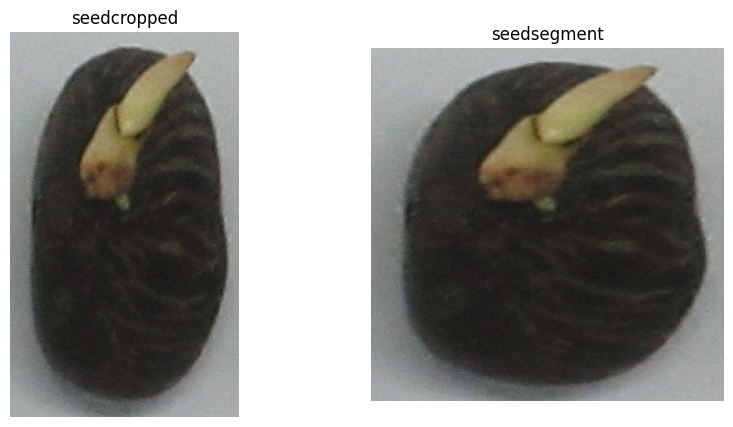



Batch 3, sample: 'badtest13.jpg'


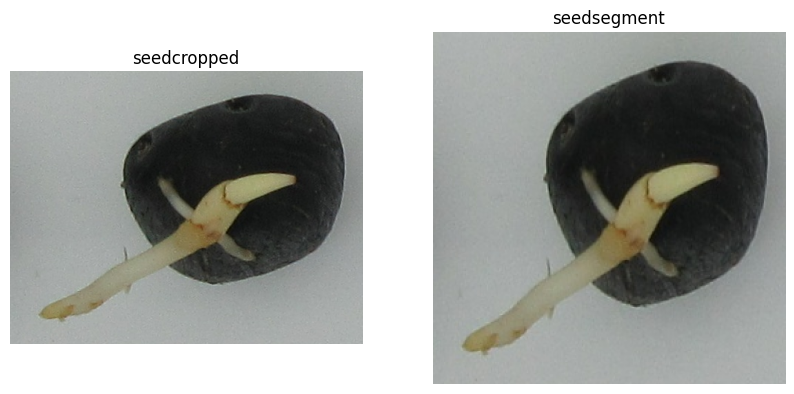

In [ ]:
def display_side_by_side(imgpath1, imgpath2):
  # Load images
  img1 = cv2.imread(imgpath1)
  img2 = cv2.imread(imgpath2)

  # Convert images from BGR to RGB (OpenCV reads images in BGR format)
  img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

  # Create a figure and subplots
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))

  # Plot images side by side
  axs[0].imshow(img1)
  axs[0].axis('off')
  axs[0].set_title('seedcropped')

  axs[1].imshow(img2)
  axs[1].axis('off')
  axs[1].set_title('seedsegment')

  # Display the plot
  plt.show()


print("Batch 2, sample: 'badtest11.jpg'")
b2imgpath1 = '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-2/seedcropped/test/BadSeed/badtest11.jpg'
b2imgpath2 = '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-2/seedsegment/test/BadSeed/badtest11.jpg'

display_side_by_side(b2imgpath1, b2imgpath2)

print("\n\nBatch 3, sample: 'badtest13.jpg'")
b3imgpath1 = '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-3/seedcropped/test/BadSeed/badtest13.jpg'
b3imgpath2 = '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-3/seedsegment/test/BadSeed/badtest13.jpg'

display_side_by_side(b3imgpath1, b3imgpath2)


# Understanding the data

In [ ]:
# Define the root directory and subdirectories
batch_dirs = ["Batch-1/seedsegment/train", "Batch-1/seedsegment/test", "Batch-2/seedsegment/test", "Batch-3/seedsegment/test"]
seed_types = ["GoodSeed", "BadSeed"]

# Iterate through each batch directory and count the images
for batch_dir in batch_dirs:
    print(f"{batch_dir}:")
    for seed_type in seed_types:
        count = 0
        for subdir, dirs, files in os.walk(os.path.join(dataset_root_dir, batch_dir)): # dataset_root_dir was defined above earlier 
            if seed_type in dirs:
                count += len(os.listdir(os.path.join(subdir, seed_type)))
        print(f"  {seed_type}: {count}")
    print()

Batch-1/seedsegment/train:
  GoodSeed: 901
  BadSeed: 851

Batch-1/seedsegment/test:
  GoodSeed: 201
  BadSeed: 200

Batch-2/seedsegment/test:
  GoodSeed: 450
  BadSeed: 450

Batch-3/seedsegment/test:
  GoodSeed: 605
  BadSeed: 593



# Custom Seed Dataset and Dataloader


As we extracted the B2 and B3 images in the same form as B1 images, we can use a single `SeedDataset` class to load all three image batches.

## SeedDataset class

In [6]:
# Custom dataset class inheriting from the PyTorch Dataset class
class SeedDataset(Dataset):
    def __init__(self, dataset_dir=None, train=True, transform=None):
        self.dataset_dir = dataset_dir
        self.train = train
        self.transform = transform
        self.categories = ['BadSeed', 'GoodSeed']
                
        self.data = []
        
        # Populating the data array by 
        data_dir = os.path.join(self.dataset_dir, 'train' if self.train else 'test')
        for category_idx, category in enumerate(self.categories):
          category_dir = os.path.join(data_dir, category)
          for img_name in os.listdir(category_dir):
              if img_name.endswith('.png') or img_name.endswith('.jpg'):
                  self.data.append((img_name, os.path.join(category_dir, img_name), category_idx))
        
        #print(self.data)
                    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
      
      img_name, img_path, label = self.data[idx]

      # Read the image file in BGR format
      image_bgr = cv2.imread(img_path)
      
      # Convert the image from BGR to RGB format
      seed_img = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

      
      if self.transform:
          seed_img = self.transform(seed_img)

      return img_name, seed_img, label

## Instantiate and load SeedDataset

**Note:** The base dataset directory was defined [above](#scrollTo=YT7yJbFiOYpn&line=1&uniqifier=1) when mounting the google drive. 
You may change the base path there or replace `os.path.join(dataset_root_dir, 'Batch-<num>/seedsegment')` below to an absolute path to the cropped (seedsegment) images in your drive for each batch.

In [7]:
# Defining paths to dataset directories
batch1_dataset_dir = os.path.join(dataset_root_dir, 'Batch-1/seedsegment')
batch2_dataset_dir = os.path.join(dataset_root_dir, 'Batch-2/seedsegment')
batch3_dataset_dir = os.path.join(dataset_root_dir, 'Batch-3/seedsegment')

**Note:** Mean and STD are calculated for the training dataset as shown in the [Get Mean and Standard Deviation of training dataset for Normalisation](#scrollTo=Yc9alNNu0NSU&line=1&uniqifier=1) section.

In [8]:
# Define the image transformations
image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5025, 0.5026, 0.4957], std=[0.2689, 0.2737, 0.2767])
])

In [9]:
# Define batch size
BATCH_SIZE = 32

In [10]:
# Get Training dataset from Batch-1
train_dataset = SeedDataset(dataset_dir=batch1_dataset_dir, train=True, transform=image_transforms)

# Split Training dataset into Training and Validation sets with a roughly 80/20 split
train_b1_dataset, validate_b1_dataset = random_split(train_dataset, [int(0.8 * len(train_dataset)), len(train_dataset) - int(0.8 * len(train_dataset))])

# Load Training and Validation datesets.
train_b1_dataloader = DataLoader(dataset=train_b1_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
validate_b1_dataloader = DataLoader(dataset=validate_b1_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Get and load Testing dataset from Batch-1,2,3
test_b1_dataset = SeedDataset(dataset_dir=batch1_dataset_dir, train=False, transform=image_transforms)
test_b1_dataloader = DataLoader(dataset=test_b1_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_b2_dataset = SeedDataset(dataset_dir=batch2_dataset_dir, train=False, transform=image_transforms)
test_b2_dataloader = DataLoader(dataset=test_b2_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_b3_dataset = SeedDataset(dataset_dir=batch3_dataset_dir, train=False, transform=image_transforms)
test_b3_dataloader = DataLoader(dataset=test_b3_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


## Get Mean and Standard Deviation of training dataset for Normalisation

You may choose to skip running this section.

**Note:** Before loading the data and calculating the mean and std, make sure to comment this line: `transforms.Normalize(mean=[0.5025, 0.5026, 0.4957], std=[0.2689, 0.2737, 0.2767])` from [image_transforms](#scrollTo=pNB1CdAbME_-&line=1&uniqifier=1) defined above. Otherwise, by running the function we will get the already normalised mean and std.


In [11]:
def get_mean_and_std(train_loader):
  mean = 0.
  std = 0.
  total_images_count = 0
  for _, images, _ in train_loader:
    
    # Get number of images in a batch, rolling count
    image_count_in_a_batch = images.size(0)
    
    # Reshape the image tensor
    #print(images.shape)
    images = images.view(image_count_in_a_batch, images.size(1), -1) # reshaping tensors from torch.Size([32, 3, 256, 256]) to torch.Size([32, 3, 65536])
    #print(images.shape)

    # Calculate the mean and std batchwise
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images_count += image_count_in_a_batch

  # Get mean and std for entire training dataset
  mean /= total_images_count
  std /= total_images_count

  print(f"Mean: {mean}")
  print(f"Standard deviation: {std}")

  return mean, std
  

It is expected to get slightly different values for mean and std each time you call get_mean_and_std() function when the calculation is done batch-wise and the samples included in each batch are randomly selected. Therefore, the statistical properties of each batch can vary slightly each time the function is called. 

As long as the differences in mean and std values between multiple runs are not significant, it is okay to use the approximated values obtained from one run for image normalization transforms. However, to get more accurate values we can increase the batch size of the data loader or use the entire dataset to calculate mean and std.

In [20]:
# Mean & STD before normalisation
mean, std = get_mean_and_std(train_b1_dataloader)

Mean: tensor([0.5025, 0.5026, 0.4957])
Standard deviation: tensor([0.2689, 0.2737, 0.2767])


**Note:** Now we will use the values obtained for [mean and std](#scrollTo=uTHx9jwt7zkU&line=1&uniqifier=1) for normalisation. You may now uncomment the previously commented line:  `transforms.Normalize(mean=mean, std=std)` and run the [image_transforms](#scrollTo=pNB1CdAbME_-&line=1&uniqifier=1) and [loader](#scrollTo=u0xTCzlXg61I&line=1&uniqifier=1) cells again.

Sanity check: after normalization the mean and std seem to be within the expected range of [0, 1] and [0, 2], respectively.

In [24]:
# Mean & STD after normalisation
mean, std = get_mean_and_std(train_b1_dataloader)

Mean: tensor([0.0064, 0.0058, 0.0058])
Standard deviation: tensor([0.9996, 0.9999, 1.0001])


# Testing dataset and dataloader

This section is just for testing purposes. You may choose to skip running it.

In [ ]:
# Checking the dataset length and a sample of data
print(f"B1 Train Dataset length: {len(train_b1_dataset)}")
print(f"B1 Train Data sample: {train_dataset.data[train_b1_dataset.indices[0]]}\n") # Access the first training sample from the original train_dataset using the index of first training sub-sample

print(f"B1 Validation Dataset length: {len(validate_b1_dataset)}")
print(f"B1 Validation Data sample: {train_dataset.data[validate_b1_dataset.indices[0]]}\n") # Access the first validation sample from the original train_dataset using the index of first validation sub-sample

print(f"B1 Test Dataset length: {len(test_b1_dataset.data)}")
print(f"B1 Test Data sample: {test_b1_dataset.data[0]}\n")

print(f"B2 Test Dataset length: {len(test_b2_dataset.data)}")
print(f"B2 Test Data sample: {test_b2_dataset.data[0]}\n")

print(f"B3 Test Dataset length: {len(test_b3_dataset.data)}")
print(f"B3 Test Data sample: {test_b3_dataset.data[0]}\n")

B1 Train Dataset length: 1401
B1 Train Data sample: ('goodtrain118.png', '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-1/seedsegment/train/GoodSeed/goodtrain118.png', 1)

B1 Validation Dataset length: 351
B1 Validation Data sample: ('badtrain413.png', '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-1/seedsegment/train/BadSeed/badtrain413.png', 0)

B1 Test Dataset length: 401
B1 Test Data sample: ('badtest2.png', '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-1/seedsegment/test/BadSeed/badtest2.png', 0)

B2 Test Dataset length: 900
B2 Test Data sample: ('badtest10.jpg', '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-2/seedsegment/test/BadSeed/badtest10.jpg', 0)

B3 Test Dataset length: 1198
B3 Test Data sample: ('badtest10.jpg', '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-3/seedsegment/test/BadSee

In [ ]:
# Get a batch of data from the data loader
b1_train_img_names, b1_train_images, b1_train_labels = next(iter(train_b1_dataloader))
b1_validate_img_names, b1_validate_images, b1_validate_labels = next(iter(validate_b1_dataloader))
b1_test_img_names, b1_test_images, b1_test_labels = next(iter(test_b1_dataloader))
b2_test_img_names, b2_test_images, b2_test_labels = next(iter(test_b2_dataloader))
b3_test_img_names, b3_test_images, b3_test_labels = next(iter(test_b3_dataloader))

## Visualise batches

B1 Train image batch shape: torch.Size([32, 3, 256, 256])
B1 Train labels batch shape: torch.Size([32])
B1 Train labels: tensor([1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 1])


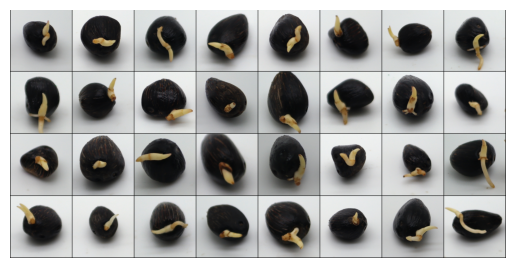

In [ ]:
# Train batch
print(f"B1 Train image batch shape: {b1_train_images.size()}")
print(f"B1 Train labels batch shape: {b1_train_labels.size()}")
print(f"B1 Train labels: {b1_train_labels}")

# Create a grid of images from the batch to see the individual seed samples
grid = vutils.make_grid(b1_train_images, nrow=8, padding=2, normalize=True)

# Display the grid
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

B1 Validate image batch shape: torch.Size([32, 3, 256, 256])
B1 Validate labels batch shape: torch.Size([32])
B1 Validate labels: tensor([0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
        1, 0, 0, 0, 1, 1, 1, 0])


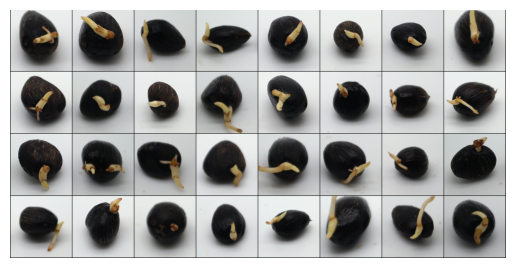

In [ ]:
# Validation batch
print(f"B1 Validate image batch shape: {b1_validate_images.size()}")
print(f"B1 Validate labels batch shape: {b1_validate_labels.size()}")
print(f"B1 Validate labels: {b1_validate_labels}")

# Create a grid of images from the batch to see the individual seed samples
grid = vutils.make_grid(b1_validate_images, nrow=8, padding=2, normalize=True)

# Display the grid
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

B1 Test image batch shape: torch.Size([32, 3, 256, 256])
B1 Test labels batch shape: torch.Size([32])
B1 Test Labels: tensor([1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
        0, 0, 1, 1, 0, 1, 0, 1])


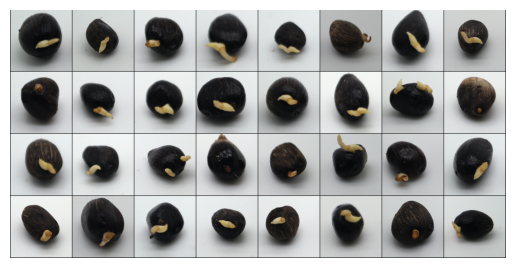

In [ ]:
# Test B1
print(f"B1 Test image batch shape: {b1_test_images.size()}")
print(f"B1 Test labels batch shape: {b1_test_labels.size()}")
print(f"B1 Test Labels: {b1_test_labels}")

# Create a grid of images from the batch to see the individual seed samples
grid = vutils.make_grid(b1_test_images, nrow=8, padding=2, normalize=True)

# Display the grid
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

B2 Test image batch shape: torch.Size([32, 3, 256, 256])
B2 Test labels batch shape: torch.Size([32])
B2 Test Labels: tensor([0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 1])


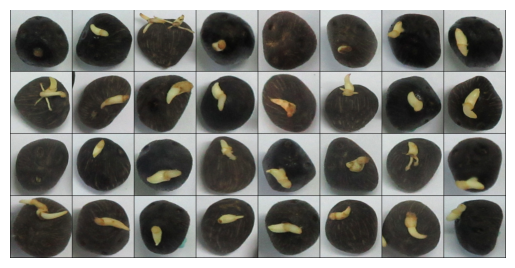

In [ ]:
# Test B2
print(f"B2 Test image batch shape: {b2_test_images.size()}")
print(f"B2 Test labels batch shape: {b2_test_labels.size()}")
print(f"B2 Test Labels: {b2_test_labels}")

# Create a grid of images from the batch to see the individual seed samples
grid = vutils.make_grid(b2_test_images, nrow=8, padding=2, normalize=True)

# Display the grid
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

B3 Test image batch shape: torch.Size([32, 3, 256, 256])
B3 Test labels batch shape: torch.Size([32])
B3 Test Labels: tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 0, 0])


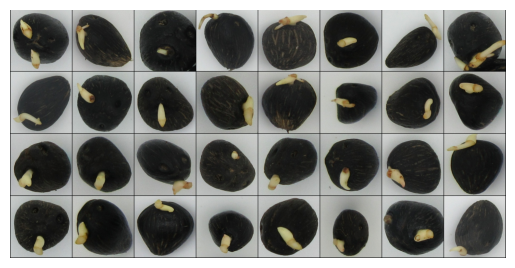

In [ ]:
# Test B3
print(f"B3 Test image batch shape: {b3_test_images.size()}")
print(f"B3 Test labels batch shape: {b3_test_labels.size()}")
print(f"B3 Test Labels: {b3_test_labels}")
# Create a grid of images from the batch to see the individual seed sample
grid = vutils.make_grid(b3_test_images, nrow=8, padding=2, normalize=True)

# Display the grid
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

# Utility functions

## train_model()

In [11]:
# Train and validate the model and log data to wandb
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25, device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
    model = model.to(device)
    wandb.watch(model, criterion, log='all', log_freq=100)

    for epoch in tqdm(range(num_epochs), desc=f"Training and validation in progress: "):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        # Iterate over the training dataset
        for batch_idx, (_, inputs, labels) in enumerate(train_loader):  # (see above) SeedDataset.__getitem__ returns: img_name, seed_img, label 

            # Uncomment this to see which batch the model is training
            # print(f"Processing batch {batch_idx+1}/{len(train_loader)}") 
            
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Print training statistics
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        wandb.log({"epoch": epoch+1, "b1_train_loss": epoch_loss, "b1_train_accuracy": epoch_acc})
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")

        # Evaluate on the validation dataset (for validation, set the test flag to false)
        val_loss, val_acc = evaluate_model("b1", model, criterion, val_loader, test=False)

    return model, optimizer, val_loss, val_acc

## evaluate_model()

In [12]:
# Evaluate the model on the validation and test sets
# The function can evaluate the model on the validation or test dataset based on the test flag.
def evaluate_model(batch_num, model, criterion, eval_loader, test=True, device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
    
    eval_mode = "test" if test else "val"
    model.eval()
    
    running_loss = 0.0
    running_corrects = 0

    # Important to set compute_on_step=False as we don't want to compute the metric for every batch during the loop \
    # but this yet updates the metric's internal state with the new data at every step. 
    # It is more efficient compute the accumulated metrics after the loop.
    precision = torchmetrics.Precision(average='macro',task="binary", compute_on_step=False, )
    recall = torchmetrics.Recall(average='macro',task="binary", compute_on_step=False)
    f1_score = torchmetrics.F1Score(average='macro', task="binary", compute_on_step=False)
    auc = torchmetrics.AUROC(task="binary", compute_on_step=False)

    with torch.no_grad():
        for _, inputs, labels in eval_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # Compute precision, recall, F1-score, and AUC using torchmetrics - to complete this operation, the tensors need to be in the CPU memory.
            labels = labels.cpu()
            preds = preds.cpu()

            precision(preds, labels)
            recall(preds, labels)
            f1_score(preds, labels)
            auc(preds, labels)

        # Print test statistics
        epoch_loss = running_loss / len(eval_loader.dataset)
        epoch_acc = running_corrects.double() / len(eval_loader.dataset)
        epoch_precision = precision.compute().item()
        epoch_recall = recall.compute().item()
        epoch_f1_score = f1_score.compute().item()
        epoch_auc = auc.compute().item()

        wandb.log({
            f"{batch_num}_{eval_mode}_loss": epoch_loss, 
            f"{batch_num}_{eval_mode}_accuracy": epoch_acc, 
        })
        
        eval_mode = "Test" if test else "Val"
        print(f"{eval_mode} Loss: {epoch_loss:.4f}, {eval_mode} Accuracy: {epoch_acc:.4f}, {eval_mode} Precision: {epoch_precision:.4f}, "
              f"{eval_mode} Recall: {epoch_recall:.4f}, {eval_mode} F1-score: {epoch_f1_score:.4f}, {eval_mode} AUC: {epoch_auc:.4f}")

    return epoch_loss, epoch_acc

## save_best_model()

In [13]:
def save_best_model(model_code, exp_name, trained_model, trained_optimizer, current_acc, best_acc, metric_name, storage_path):
    # Save the model only if the current test accuracy is better than the previously stored model's test accuracy
    if current_acc > best_acc:
        print(f"{metric_name} improved from {best_acc:.4f} to {current_acc:.4f}. Saving model...\n")
        best_acc = current_acc
        
        # saving both the model and optimizer state together
        state = {
            'experiment_name': exp_name,
            'model_state_dict': trained_model.state_dict(),
            'optimizer_state_dict': trained_optimizer.state_dict()
        }
        file_name = f"{storage_path}/{model_code}_best_{metric_name}_model.pt"
        torch.save(state, file_name)

        # Create wandb artifact to save the model with a wandb run
        artifact = wandb.Artifact(f"{model_code}_best_{metric_name}_model.pt", type='model')

        # add the saved model file to the artifact
        artifact.add_file(file_name)

        # log the artifact to Wandb
        wandb.log_artifact(artifact)

    return best_acc

## freeze_layers()

In [14]:
def freeze_layers(model, freeze=True, last_layer_name="fc"):
    if freeze:
        # Freeze all layers except the last one
        for param in model.parameters():
            param.requires_grad = False

        # Unfreeze the last layer
        last_layer = getattr(model, last_layer_name)
        for param in last_layer.parameters():
            param.requires_grad = True
    return model

## run_experiment()

**Experiment Setup**

* Cross-entropy loss is used as the loss function because it measures the performance of a classification model whose output is a probability value between 0 and 1, as is the case here. Cross-entropy loss increases as the predicted probability diverges from the actual label, effectively penalising the model for incorrect predictions.

* We used the Weights & Biases (wandb) library to monitor the model's training progress, and log the hyperparameters, loss and accuracy for the training, validation and test sets for each experiment. 

In [15]:
# Run experiments with different hyperparameter values (Hyperparameters => optimizer, epochs)
def run_experiment(best_accuracies, exp_name, model, optimizer_type, optimizer_args, epochs, freeze=False, transfer_learning=True):
    
    if transfer_learning:
      model_code = 'TL_CNN'
    else:
      model_code = 'CNN'

    # Keeping track of the model with the best accuracy across different experiments
    best_val_acc = best_accuracies['val_acc']
    best_b1_test_acc = best_accuracies['b1_test_acc']
    best_b2_test_acc = best_accuracies['b2_test_acc']
    best_b3_test_acc = best_accuracies['b3_test_acc']

    # For transfer learning with Resnet18 model - Freeze the pre-trained layers if freeze flag is true (not freezing aka updating the weights of the pre-trained layers is computationally expensive)
    if freeze:
      freeze_layers(model)
      print("Froze all layers of the model except the last layer\n")

    # Define the loss function
    criterion = nn.CrossEntropyLoss()

    # Create the optimizer with the given type and arguments for current experiment
    optimizer = optimizer_type(model.parameters(), **optimizer_args)

    config = {
        'optimizer': optimizer.__class__.__name__, # retrieves the name of the optimizer's class (e.g., 'SGD', 'Adagrad') by accessing the optimizer's class attribute __name__.
        'learning_rate': optimizer.param_groups[0]['lr'], # retrieves the learning rate of the first (and typically only) parameter group by accessing the lr key in the dictionary.
        'momentum': optimizer.param_groups[0].get('momentum', None), # attempts to retrieve the momentum of the first parameter group by accessing the momentum key in the dictionary. If the momentum key is not found (e.g., for optimizers that don't use momentum), the get() method will return None. 
        'alpha': optimizer.param_groups[0].get('alpha', None),
        'betas': optimizer.param_groups[0].get('betas', None),
        'num_epochs': epochs,
        'freeze': freeze,
    }

    with wandb.init(project='seed-classification', config=config, group=exp_name, name=f'{exp_name}_optimizer_{config["optimizer"]}_epochs_{epochs}_freeze_{freeze}'):
     
        # Train the model with B1 data
        print("\nTrain and Validate")
        trained_model, trained_optimizer, val_loss, val_acc = train_model(model, criterion, optimizer, train_b1_dataloader, validate_b1_dataloader, num_epochs=epochs)
        
        # Test the model with B1, B2, and B3 data
        print("\nTest Batch-1")
        b1_test_loss, b1_test_acc = evaluate_model("b1", model, criterion, test_b1_dataloader, test=True)
 
        print("\nTest Batch-2")
        b2_test_loss, b2_test_acc = evaluate_model("b2", model, criterion, test_b2_dataloader, test=True)
        
        print("\nTest Batch-3")
        b3_test_loss, b3_test_acc = evaluate_model("b3", model, criterion, test_b3_dataloader, test=True)

        print() # new line
        storage_path = "/content/drive/MyDrive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Best-Models"

        # Save the model based on the best (val, b1_test, b2_test, b3_test) accuracy - keeping track of all 4 accuracies
        best_val_acc = save_best_model(model_code, exp_name, trained_model, trained_optimizer, val_acc, best_val_acc, "val_acc", storage_path)
        best_b1_test_acc = save_best_model(model_code, exp_name, trained_model, trained_optimizer, b1_test_acc, best_b1_test_acc, "b1_test_acc", storage_path)
        best_b2_test_acc = save_best_model(model_code, exp_name, trained_model, trained_optimizer, b2_test_acc, best_b2_test_acc, "b2_test_acc", storage_path)
        best_b3_test_acc = save_best_model(model_code, exp_name, trained_model, trained_optimizer, b3_test_acc, best_b3_test_acc, "b3_test_acc", storage_path)
    
    # Update global best accuracies
    best_accuracies = {
    "val_acc": best_val_acc,
    "b1_test_acc": best_b1_test_acc,
    "b2_test_acc": best_b2_test_acc,
    "b3_test_acc": best_b3_test_acc,
    }
    return best_accuracies

# Transfer Learning with pre-trained ResNet18 model 

* We will be using the ResNet18 model for this task. The model is fine-tuned for binary classification (GoodSeed or BadSeed) by replacing the last fully connected layer.

* The subsection, [Experiments](#scrollTo=sKi5AHxzOpfn&line=1&uniqifier=1), shows the different experiments we conducted and the different hyperparameters we considered to reach the final version of the model.

## create_resnet18_model()

In [16]:
# Define a function that returns the modified ResNet-18 model
def create_resnet18_model():
    # Load the pre-trained ResNet-18 model
    resnet18_model = resnet18(pretrained=True)

    print("\nPre-trained ResNet-18 model created\n")

    # Modify the resnet18 model for binary classification (GoodSeed or BadSeed)
    # Replace the last fully connected layer with a new one for binary classification
    num_classes = 2   # [BadSeed, GoodSeed] 
    resnet18_model.fc = nn.Linear(resnet18_model.fc.in_features, num_classes)

    # Sanity check - check if last FC layer has been replaced correctly
    #print(resnet18_model)

    return resnet18_model

## Experiments

### Methodology

We conducted 3 experiments using different hyperparameters and each experiment was run twice. 

The number of epochs was set to `10` for all runs, for better comparison of the different optimisation algorithms used. 

Optimisation algorithms used are Exp-1: `SGD with Momentum`, Exp-2: `RMSprop`, Exp-3: `Adam`.

For each experiment, in Run 1 the pre-trained layers were frozen by setting the freeze flag to `True`, hence the parameters/weights for these layers were not being updated. 

In Run 2, however, we set freeze to `False` to update the weights of the pre-trained layers. By not freezing the layers, the model is able to learn task-specific features by updating the weights of the entire network during training. The model can adapt better to the new dataset, capturing more complex patterns and nuances that may not have been present in the original dataset. This can lead to better performance. Albeit, this comes at a computational cost.



**Note:** Before running any experiments please make sure to run the cells for **all** the [utility functions](#scrollTo=COnU5pJu9lWI&line=3&uniqifier=1) to load them.

In [17]:
# Keep track of the models with the best accuracies for each evaluation set across experiments
best_accuracies = {
    "val_acc": 0.0,
    "b1_test_acc": 0.0,
    "b2_test_acc": 0.0,
    "b3_test_acc": 0.0
}

### Experiment 1


- Stochastic Gradient Descent (SGD) optimizer with momentum is used for optimization with `learning_rate=0.001` and `momentum=0.9`. We selected these values as a starting point as they are default values that have been proven to work well in practice for many deep learning tasks.

#### Run 1

In [18]:
# Define the optimizer type and its args
optimizer_SGD_args = {'lr': 0.001, 'momentum': 0.9}
best_accuracies = run_experiment(best_accuracies, "TL_CNN_Exp_1", create_resnet18_model(), optim.SGD, optimizer_SGD_args, epochs=10, freeze=True, transfer_learning=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]



Pre-trained ResNet-18 model created

Froze all layers of the model except the last layer



wandb: Currently logged in as: bidmalvi. Use `wandb login --relogin` to force relogin



Train and Validate


Training and validation in progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Training Loss: 0.5934, Training Accuracy: 0.6838
Val Loss: 0.4712, Val Accuracy: 0.8262, Val Precision: 0.7864, Val Recall: 0.9050, Val F1-score: 0.8416, Val AUC: 0.8246
Epoch 2/10, Training Loss: 0.4189, Training Accuracy: 0.8287
Val Loss: 0.3808, Val Accuracy: 0.8604, Val Precision: 0.8736, Val Recall: 0.8492, Val F1-score: 0.8612, Val AUC: 0.8606
Epoch 3/10, Training Loss: 0.3741, Training Accuracy: 0.8544
Val Loss: 0.3454, Val Accuracy: 0.8689, Val Precision: 0.8715, Val Recall: 0.8715, Val F1-score: 0.8715, Val AUC: 0.8689
Epoch 4/10, Training Loss: 0.3334, Training Accuracy: 0.8744
Val Loss: 0.3694, Val Accuracy: 0.8319, Val Precision: 0.9286, Val Recall: 0.7263, Val F1-score: 0.8150, Val AUC: 0.8341
Epoch 5/10, Training Loss: 0.3165, Training Accuracy: 0.8844
Val Loss: 0.3309, Val Accuracy: 0.8604, Val Precision: 0.9167, Val Recall: 0.7989, Val F1-score: 0.8537, Val AUC: 0.8617
Epoch 6/10, Training Loss: 0.3456, Training Accuracy: 0.8601
Val Loss: 0.3301, Val Accurac

b1_test_accuracy,▁
b1_test_loss,▁
b1_train_accuracy,▁▆▆▇▇▇▇▇▇█
b1_train_loss,█▄▃▃▂▃▂▂▂▁
b1_val_accuracy,▁▅▆▂▅▃▆▆▃█
b1_val_loss,█▅▃▄▃▃▂▂▃▁
b2_test_accuracy,▁
b2_test_loss,▁
b3_test_accuracy,▁
b3_test_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█


#### ✅ Run 2

In [21]:
# Define the optimizer type and its args
optimizer_SGD_args = {'lr': 0.001, 'momentum': 0.9}
best_accuracies = run_experiment(best_accuracies, "TL_CNN_Exp_1", create_resnet18_model(), optim.SGD, optimizer_SGD_args, epochs=10, freeze=False, transfer_learning=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Pre-trained ResNet-18 model created




Train and Validate


Training and validation in progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Training Loss: 0.4849, Training Accuracy: 0.7623
Val Loss: 0.2117, Val Accuracy: 0.9259, Val Precision: 0.9527, Val Recall: 0.8994, Val F1-score: 0.9253, Val AUC: 0.9265
Epoch 2/10, Training Loss: 0.1521, Training Accuracy: 0.9443
Val Loss: 0.1103, Val Accuracy: 0.9601, Val Precision: 0.9508, Val Recall: 0.9721, Val F1-score: 0.9613, Val AUC: 0.9599
Epoch 3/10, Training Loss: 0.0687, Training Accuracy: 0.9793
Val Loss: 0.1925, Val Accuracy: 0.9202, Val Precision: 0.9935, Val Recall: 0.8492, Val F1-score: 0.9157, Val AUC: 0.9217
Epoch 4/10, Training Loss: 0.0526, Training Accuracy: 0.9864
Val Loss: 0.0745, Val Accuracy: 0.9744, Val Precision: 0.9670, Val Recall: 0.9832, Val F1-score: 0.9751, Val AUC: 0.9742
Epoch 5/10, Training Loss: 0.0468, Training Accuracy: 0.9843
Val Loss: 0.1182, Val Accuracy: 0.9658, Val Precision: 0.9883, Val Recall: 0.9441, Val F1-score: 0.9657, Val AUC: 0.9663
Epoch 6/10, Training Loss: 0.0226, Training Accuracy: 0.9957
Val Loss: 0.0538, Val Accurac

b1_test_accuracy,▁
b1_test_loss,▁
b1_train_accuracy,▁▆▇███████
b1_train_loss,█▃▂▂▂▁▁▁▁▁
b1_val_accuracy,▂▅▁▇▆█▇█▇█
b1_val_loss,█▄▇▂▄▁▂▁▁▁
b2_test_accuracy,▁
b2_test_loss,▁
b3_test_accuracy,▁
b3_test_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█


### Experiment 2

#### Run 1

In [19]:
optimizer_rmsprop_args = {'lr': 0.001, 'alpha': 0.99}
best_accuracies = run_experiment(best_accuracies, "TL_CNN_Exp_2", create_resnet18_model(), torch.optim.RMSprop, optimizer_rmsprop_args, epochs=10, freeze=True, transfer_learning=True)



Pre-trained ResNet-18 model created

Froze all layers of the model except the last layer




Train and Validate


Training and validation in progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Training Loss: 0.6689, Training Accuracy: 0.6945
Val Loss: 0.4365, Val Accuracy: 0.8462, Val Precision: 0.7907, Val Recall: 0.9497, Val F1-score: 0.8629, Val AUC: 0.8440
Epoch 2/10, Training Loss: 0.4268, Training Accuracy: 0.8151
Val Loss: 0.3741, Val Accuracy: 0.8462, Val Precision: 0.8788, Val Recall: 0.8101, Val F1-score: 0.8430, Val AUC: 0.8469
Epoch 3/10, Training Loss: 0.3906, Training Accuracy: 0.8365
Val Loss: 0.3492, Val Accuracy: 0.8604, Val Precision: 0.9012, Val Recall: 0.8156, Val F1-score: 0.8563, Val AUC: 0.8613
Epoch 4/10, Training Loss: 0.3637, Training Accuracy: 0.8480
Val Loss: 0.3457, Val Accuracy: 0.8433, Val Precision: 0.9133, Val Recall: 0.7654, Val F1-score: 0.8328, Val AUC: 0.8449
Epoch 5/10, Training Loss: 0.3483, Training Accuracy: 0.8522
Val Loss: 0.4201, Val Accuracy: 0.7920, Val Precision: 0.7172, Val Recall: 0.9777, Val F1-score: 0.8274, Val AUC: 0.7882
Epoch 6/10, Training Loss: 0.3282, Training Accuracy: 0.8680
Val Loss: 0.3170, Val Accurac

b1_test_accuracy,▁
b1_test_loss,▁
b1_train_accuracy,▁▅▆▆▇▇▇▇██
b1_train_loss,█▄▃▃▂▂▂▁▁▁
b1_val_accuracy,▅▅▆▅▁▇▆█▆█
b1_val_loss,█▅▄▃▇▂▂▁▂▁
b2_test_accuracy,▁
b2_test_loss,▁
b3_test_accuracy,▁
b3_test_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█


#### Run 2

In [23]:
optimizer_rmsprop_args = {'lr': 0.001, 'alpha': 0.99}
best_accuracies = run_experiment(best_accuracies, "TL_CNN_Exp_2", create_resnet18_model(), torch.optim.RMSprop, optimizer_rmsprop_args, epochs=10, freeze=False, transfer_learning=True)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Pre-trained ResNet-18 model created




Train and Validate


Training and validation in progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Training Loss: 0.7331, Training Accuracy: 0.6738
Val Loss: 7.8540, Val Accuracy: 0.4929, Val Precision: 1.0000, Val Recall: 0.0056, Val F1-score: 0.0111, Val AUC: 0.5028
Epoch 2/10, Training Loss: 0.3213, Training Accuracy: 0.8680
Val Loss: 0.9287, Val Accuracy: 0.5641, Val Precision: 0.5392, Val Recall: 1.0000, Val F1-score: 0.7006, Val AUC: 0.5552
Epoch 3/10, Training Loss: 0.2670, Training Accuracy: 0.8929
Val Loss: 0.5148, Val Accuracy: 0.8148, Val Precision: 0.7415, Val Recall: 0.9777, Val F1-score: 0.8434, Val AUC: 0.8115
Epoch 4/10, Training Loss: 0.1745, Training Accuracy: 0.9379
Val Loss: 0.2130, Val Accuracy: 0.9174, Val Precision: 0.9464, Val Recall: 0.8883, Val F1-score: 0.9164, Val AUC: 0.9180
Epoch 5/10, Training Loss: 0.1672, Training Accuracy: 0.9386
Val Loss: 0.3986, Val Accuracy: 0.8291, Val Precision: 0.9760, Val Recall: 0.6816, Val F1-score: 0.8026, Val AUC: 0.8321
Epoch 6/10, Training Loss: 0.1194, Training Accuracy: 0.9557
Val Loss: 0.1142, Val Accurac

b1_test_accuracy,▁
b1_test_loss,▁
b1_train_accuracy,▁▆▆███▇███
b1_train_loss,█▃▃▂▂▁▂▁▁▁
b1_val_accuracy,▁▂▆▇▆███▅▆
b1_val_loss,█▂▁▁▁▁▁▁▂▁
b2_test_accuracy,▁
b2_test_loss,▁
b3_test_accuracy,▁
b3_test_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█


### Experiment 3

#### Run 1

In [20]:
optimizer_Adam_args = {'lr': 0.001, 'betas': (0.9, 0.999)}
best_accuracies = run_experiment(best_accuracies, "TL_CNN_Exp_3", create_resnet18_model(), optim.Adam, optimizer_Adam_args, epochs=10, freeze=True, transfer_learning=True)



Pre-trained ResNet-18 model created

Froze all layers of the model except the last layer




Train and Validate


Training and validation in progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Training Loss: 0.6339, Training Accuracy: 0.6567
Val Loss: 0.5275, Val Accuracy: 0.7407, Val Precision: 0.8729, Val Recall: 0.5754, Val F1-score: 0.6936, Val AUC: 0.7441
Epoch 2/10, Training Loss: 0.4654, Training Accuracy: 0.7937
Val Loss: 0.4240, Val Accuracy: 0.8462, Val Precision: 0.8931, Val Recall: 0.7933, Val F1-score: 0.8402, Val AUC: 0.8472
Epoch 3/10, Training Loss: 0.3869, Training Accuracy: 0.8594
Val Loss: 0.3768, Val Accuracy: 0.8775, Val Precision: 0.9048, Val Recall: 0.8492, Val F1-score: 0.8761, Val AUC: 0.8781
Epoch 4/10, Training Loss: 0.3597, Training Accuracy: 0.8658
Val Loss: 0.3578, Val Accuracy: 0.8632, Val Precision: 0.9338, Val Recall: 0.7877, Val F1-score: 0.8545, Val AUC: 0.8648
Epoch 5/10, Training Loss: 0.3325, Training Accuracy: 0.8737
Val Loss: 0.3388, Val Accuracy: 0.8547, Val Precision: 0.8048, Val Recall: 0.9441, Val F1-score: 0.8689, Val AUC: 0.8529
Epoch 6/10, Training Loss: 0.3140, Training Accuracy: 0.8794
Val Loss: 0.3457, Val Accurac

/usr/local/lib/python3.9/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Test Loss: 0.6290, Test Accuracy: 0.6912, Test Precision: 0.6968, Test Recall: 0.6876, Test F1-score: 0.6922, Test AUC: 0.6912

b3_test_acc improved from 0.6686 to 0.6912. Saving model...



b1_test_accuracy,▁
b1_test_loss,▁
b1_train_accuracy,▁▅▇█████▇█
b1_train_loss,█▅▃▂▂▂▁▁▂▁
b1_val_accuracy,▁▆█▇▇▆▆▇▇▆
b1_val_loss,█▅▃▃▂▂▂▁▁▁
b2_test_accuracy,▁
b2_test_loss,▁
b3_test_accuracy,▁
b3_test_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█


#### Run 2

In [22]:
optimizer_Adam_args = {'lr': 0.001, 'betas': (0.9, 0.999)}
best_accuracies = run_experiment(best_accuracies, "TL_CNN_Exp_3", create_resnet18_model(), optim.Adam, optimizer_Adam_args, epochs=10, freeze=False, transfer_learning=True)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Pre-trained ResNet-18 model created




Train and Validate


Training and validation in progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Training Loss: 0.3133, Training Accuracy: 0.8715
Val Loss: 0.2670, Val Accuracy: 0.9088, Val Precision: 0.9682, Val Recall: 0.8492, Val F1-score: 0.9048, Val AUC: 0.9100
Epoch 2/10, Training Loss: 0.1367, Training Accuracy: 0.9522
Val Loss: 0.1054, Val Accuracy: 0.9544, Val Precision: 0.9358, Val Recall: 0.9777, Val F1-score: 0.9563, Val AUC: 0.9539
Epoch 3/10, Training Loss: 0.1025, Training Accuracy: 0.9600
Val Loss: 0.2482, Val Accuracy: 0.9202, Val Precision: 0.9871, Val Recall: 0.8547, Val F1-score: 0.9162, Val AUC: 0.9216
Epoch 4/10, Training Loss: 0.1207, Training Accuracy: 0.9529
Val Loss: 0.2804, Val Accuracy: 0.8946, Val Precision: 0.8777, Val Recall: 0.9218, Val F1-score: 0.8992, Val AUC: 0.8940
Epoch 5/10, Training Loss: 0.1113, Training Accuracy: 0.9600
Val Loss: 0.0695, Val Accuracy: 0.9744, Val Precision: 0.9722, Val Recall: 0.9777, Val F1-score: 0.9749, Val AUC: 0.9743
Epoch 6/10, Training Loss: 0.0723, Training Accuracy: 0.9736
Val Loss: 0.9224, Val Accurac

b1_test_accuracy,▁
b1_test_loss,▁
b1_train_accuracy,▁▆▆▆▆▇▇█▇█
b1_train_loss,█▃▃▃▃▂▂▁▂▁
b1_val_accuracy,▆▇▆▅█▁██▂▅
b1_val_loss,▃▁▂▃▁█▁▁▆▄
b2_test_accuracy,▁
b2_test_loss,▁
b3_test_accuracy,▁
b3_test_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█


### ✨ Results

✨ **Experiment 1 results** 

Firstly, a noticable trend across all experiments and runs is that the model's are performing well on the Training and Validation sets, as well as on Test Batch-1. However, its performance drops significantly on Test Batch-2 and Test Batch-3, indicating that the model may not generalize well to these new data batches.

As observed below, the model is performing well on the Training and Validation sets, as well as on Test Batch-1. However, its performance drops significantly on Test Batch-2 and Test Batch-3, indicating that the model may not generalize well to these new data batches. One contributing factor could be that the images in B1, B2 and B3 were shot under different lighting conditions. Since the model was trained using B1, it may have learned specific features to B1, in other words, overfitting the training data. Further analysis and experimentation is required to understand and improve the model's performance on the latter two datasets. 

## Load the best Transfer Learning CNN model

In [25]:
# Define the model architecture
model = create_resnet18_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Load the saved state dictionaries
saved_path = "/content/drive/MyDrive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Best-Models/TL_CNN_best_b1_test_acc_model.pt"
saved_state = torch.load(saved_path)

exp_name = saved_state['experiment_name']
model.load_state_dict(saved_state['model_state_dict'])
optimizer.load_state_dict(saved_state['optimizer_state_dict'])



Pre-trained ResNet-18 model created



Loaded model is the best model which was generated and saved from Experiment-1 Run-2. 
( [see results above](#scrollTo=KgiuDJkKWFFX&line=1&uniqifier=1))

```
val_acc improved from 0.8917 to 0.9858. Saving model...
b1_test_acc improved from 0.8753 to 0.9776. Saving model...
b2_test_acc improved from 0.5978 to 0.8400. Saving model...
b3_test_acc improved from 0.6912 to 0.8456. Saving model...
```

In [26]:
print(exp_name)
print(f"Best Validation Accuracy: {best_accuracies['val_acc']}")
print(f"Best B1 Test Accuracy: {best_accuracies['b1_test_acc']}")
print(f"Best B2 Test Accuracy: {best_accuracies['b2_test_acc']}")
print(f"Best B3 Test Accuracy: {best_accuracies['b3_test_acc']}")

TL_CNN_Exp_1
Best Validation Accuracy: 0.9857549857549858
Best B1 Test Accuracy: 0.9775561097256857
Best B2 Test Accuracy: 0.84
Best B3 Test Accuracy: 0.8455759599332221


## Visualisation

### Visualise learned weights

### Visualise feature maps

### Visualise the saliency map

In [27]:
# Define image samples to visualise saliency maps for
good_seed_img_path = "/content/drive/MyDrive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-1/seedsegment/test/GoodSeed/goodtest0.png"
bad_seed_img_path = "/content/drive/MyDrive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-1/seedsegment/test/BadSeed/badtest0.png"

We will apply the same [`image_transforms`](#scrollTo=pNB1CdAbME_-&line=4&uniqifier=1) which we used to prepare the datasets for training and testing, defined above.

#### Saliency Map with Vanilla Backpropagation

In [28]:
# Prep the input image as they were pre-processed during the training/testing phase
def generate_saliency_map(model, image_path):
    
    # Read the image file in BGR format and convert it from BGR to RGB format
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    
    # Preprocess image
    preprocess = image_transforms
    input_image = preprocess(image).unsqueeze(0)

    # Set requires_grad=True for the input image to compute gradients
    input_image.requires_grad = True

    # Forward pass
    model.eval()
    output = model(input_image)

    print(f"Models Output: {output}\n")

    # Get the index of the maximum prediction
    pred_class = torch.argmax(output).item()

    # Compute the gradients of the output with respect to the input image
    output[0, pred_class].backward()

    # Get the absolute values of the gradients and normalize them
    saliency, _ = torch.max(input_image.grad.data.abs(), dim=1)
    saliency = saliency.squeeze().numpy()

    # Plot the original image and the saliency map
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(saliency, cmap='hot')
    plt.axis('off')
    plt.title('Saliency Map')
    plt.show()


Models Output: tensor([[-4.4202,  4.3674]], grad_fn=<AddmmBackward0>)



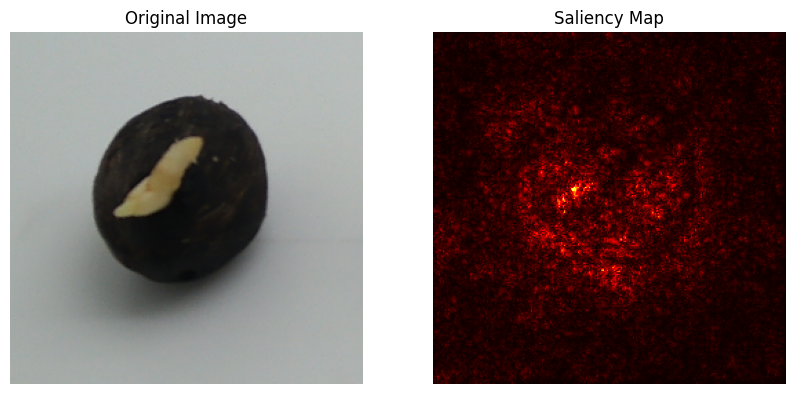

In [29]:
generate_saliency_map(model, good_seed_img_path)

Models Output: tensor([[-0.3596,  0.1042]], grad_fn=<AddmmBackward0>)



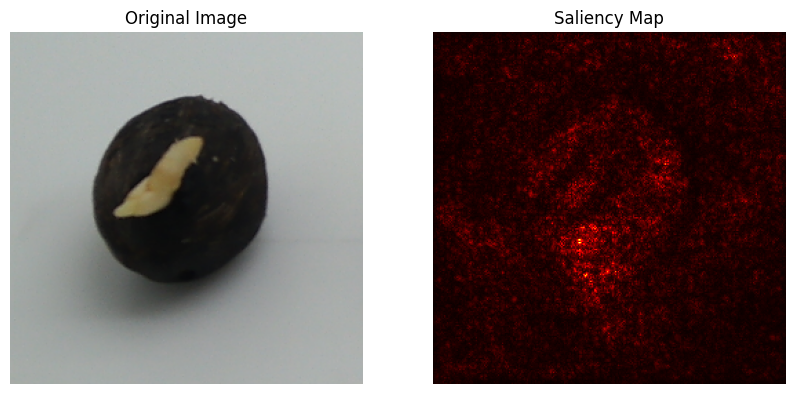

In [ ]:
#to delete
generate_saliency_map(model, good_seed_img_path)

Models Output: tensor([[ 4.0995, -3.9433]], grad_fn=<AddmmBackward0>)



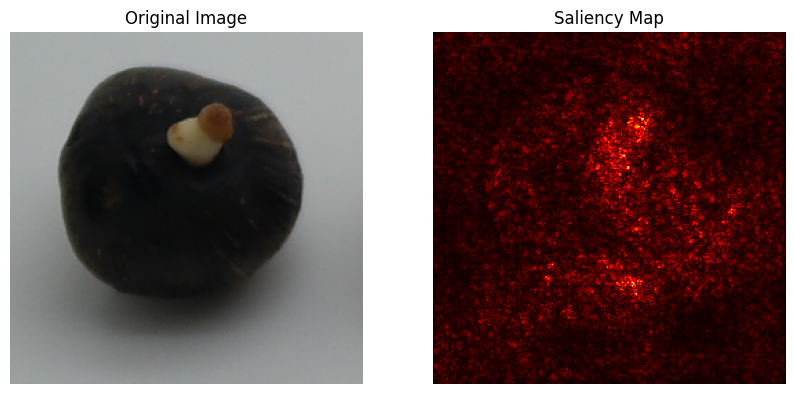

In [30]:
generate_saliency_map(model, bad_seed_img_path)

Models Output: tensor([[0.3150, 0.1880]], grad_fn=<AddmmBackward0>)



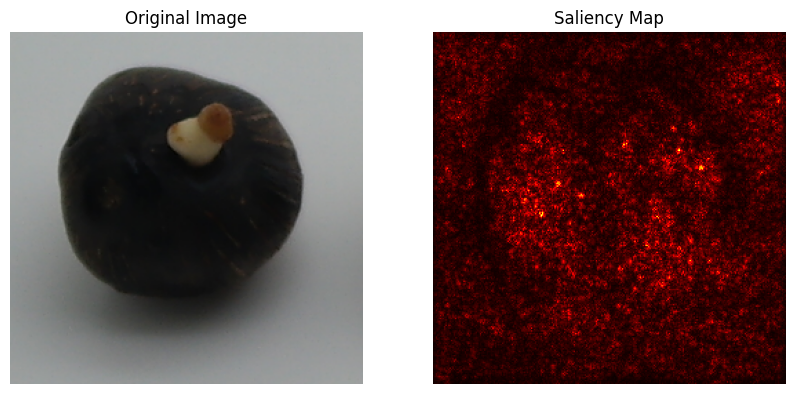

In [ ]:
#to delete
generate_saliency_map(model, bad_seed_img_path)

#### Saliency Map with Guided Backpropagation

### Visualise the heatmap